In [12]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

origin_data = pd.read_csv("./data/train.csv")
submission_data = pd.read_csv("./data/test.csv")


- Handle the null values of text and summary columns. If we find one in either column we replace it with an empty string.
- Since we are going to use TFIDF vectorization later and we care about the individual words, we combine both of the 'Text' and 'Summary' columns into one.
- Clean the combine textual info from URLs, punctuations, speecial characters and lowercase the words.
- During the TFIDF vectorization we remove the stop-words, which do not put any importance to the textual info. 
- Keep as words only those we have seen at least two times (no stopwords of course) to increase the importance of words included in the corpus.  

In [4]:
origin_data['Text'].loc[origin_data['Text'].isnull()] = ''
origin_data['Summary'].loc[origin_data['Summary'].isnull()] = ''

origin_data["Textual_Info"] = origin_data['Text'] + origin_data['Summary']
columns_to_drop = ['Id', 'Time', 'Text', 'Summary']
origin_data = origin_data.drop(columns=columns_to_drop)
origin_data.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Textual_Info
0,0005019281,ADZPIG9QOCDG5,0,0,4.0,This is a charming version of the classic Dick...
1,0005019281,A35947ZP82G7JH,0,0,3.0,It was good but not as emotionally moving as t...
2,0005019281,A3UORV8A9D5L2E,0,0,3.0,"Don't get me wrong, Winkler is a wonderful cha..."
3,0005019281,A1VKW06X1O2X7V,0,0,5.0,Henry Winkler is very good in this twist on th...
4,0005019281,A3R27T4HADWFFJ,0,0,4.0,This is one of the best Scrooge movies out. H...


In [5]:
def clean_documents(doc):
    doc = str(doc).lower()  # Lowercase conversion
    doc = re.sub('\[.*?\]', '', doc)
    doc = re.sub('https?://\S+|http?://\S+|www\.\S+', '', doc)  # Remove URls
    doc = re.sub('<.*?>+', '', doc)
    doc = re.sub(r'[^a-z0-9\s]', '', doc)  # Remove punctuation
    doc = re.sub('\n', '', doc)
    doc = re.sub('\w*\d\w*', '', doc)
    return doc

print("Start cleaning Textual_Info column...")
origin_data['Textual_Info'] = origin_data['Textual_Info'].apply(clean_documents)

Start cleaning Textual_Info column...


- Implement TFIDF vectorization on the combined textual info column using a corpus of at least two times used words and with no stopwords. TFIDF vectorization is fitted on train data and transformed on train and test data otherwise we are overfitting with words of test data. I was inspired for this solution as it was used in homework 3 exercise 2(c).
- Implement One hot encoding on 'ProductId' and 'UserId'. It is important to notice that the fitting is done on the train data and transformed on train and test data otherwise we are overfitting with test 'productId' and 'UserId'. To ignore unknown 'ProductId' and 'UserId' i used a parameter called 'handle_unknown' on OneHotEncoder() definition. I was inspired for this solution based on instructor Saurav vara prasad chennuri when he replied on homework 2 about one hot encoding the 'Title' column of Titanic dataset.
- Used the 'Helpfulness' column as it was proposed in the initial feature extraction from the professor Lance Galletti and I believe is a clever way to incorporate the information of both columns 'HelpfulnessNumerator' and 'HelpfulnessDenominator' into one. 

In [6]:
# Split the original given origin_data dataframe to train_df and test_df 
train_df = origin_data[origin_data['Score'].notna()]
test_df = origin_data[origin_data['Score'].isnull()]
train_Y = train_df.reset_index()['Score']

# Prepare the train dataset
train_df['Helpfulness'] = train_df['HelpfulnessNumerator'] / train_df['HelpfulnessDenominator']
train_df['Helpfulness'] = train_df['Helpfulness'].fillna(0)
train_helpfulness_matrix = csr_matrix(train_df[['Helpfulness']].values)

# Fit the one hot encoder on train dataset and tranform it too.
productID_encoder = OneHotEncoder(handle_unknown='ignore').fit(train_df[['ProductId']])
train_productID_encoded = productID_encoder.transform(train_df[['ProductId']])
userID_encoder = OneHotEncoder(handle_unknown='ignore').fit(train_df[['UserId']])
train_userID_encoded = userID_encoder.transform(train_df[['UserId']])

# Fit the TFIDF vectorizer on train dataset and tranform it too.
stop_words = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(min_df=2, stop_words=stop_words)
textual_info_vectorizer = vectorizer.fit(train_df['Textual_Info'])
train_textual_info_vectorized = textual_info_vectorizer.transform(train_df['Textual_Info'])

# Combine all the features vectors into one matrix
train_data_stacked = hstack([train_textual_info_vectorized, train_productID_encoded, train_userID_encoded, train_helpfulness_matrix])
train_X = csr_matrix(train_data_stacked)

In [7]:
# Prepare the test dataset
test_df['Helpfulness'] = test_df['HelpfulnessNumerator'] / test_df['HelpfulnessDenominator']
test_df['Helpfulness'] = test_df['Helpfulness'].fillna(0)
test_helpfulness_matrix = csr_matrix(test_df[['Helpfulness']].values)

# Only transform the test dataset based on the one hot encoder of train dataset!
test_productID_encoded = productID_encoder.transform(test_df[['ProductId']])
test_userID_encoded = userID_encoder.transform(test_df[['UserId']])

# Only transform the test dataset based on the TFIDF vectorizer of train dataset!
test_textual_info_vectorized = textual_info_vectorizer.transform(test_df['Textual_Info'])

# Combine all the features vectors into one matrix
test_data_stacked = hstack([test_textual_info_vectorized, test_productID_encoded, test_userID_encoded, test_helpfulness_matrix])
test_X = csr_matrix(test_data_stacked)


I worked with 2 different classifiers. Logistic regression and Randomforest.  
In order to make sure that I used the optimal model of the chosen classifier I trained the model of the chosen classifier on a KFold environment with 10 splits and I took the model with the maximum accuracy out of those 10. The inspiration of this evaluation technique was based on the following article: https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6. 

In [15]:
# Implements a 10 Kfold split of train dataset in which we calculate the accuracy & hold 
# the model with the best accuracy to use it later for predicting the submission test data
def bestmodel(model, X, y):
    max_accuracy = -1
    optimal_model = model
    cv = KFold(n_splits=10, random_state= 1, shuffle=True)
    for train_index, test_index in cv.split(X):
        model.fit(X[train_index], y[train_index])
        y_pred = model.predict(X[test_index])
        current_accuracy = (accuracy_score(y_pred, y[test_index]) * 100).__round__(2)
        if(max_accuracy < current_accuracy):
            max_accuracy = current_accuracy
            optimal_model = model
    return max_accuracy, optimal_model

Maximum accuracy for logistic regression is 66.81


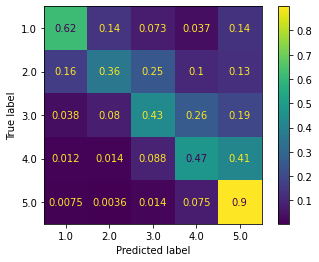

In [9]:
# Apply the logistic regression model with a Kfold evaluation metric. 
# At the end plot the confusion matric of the produced model
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2)
log_reg_model = LogisticRegression()
max_accuracy, optimal_model = bestmodel(log_reg_model, train_X, train_Y)
print("Maximum accuracy for logistic regression is {}".format(max_accuracy))
final_predictions = pd.DataFrame(optimal_model.predict(test_X))[0]
submission_data["Score"] = final_predictions
submission_data.to_csv('log_reg_submission.csv',index=False)
plot_confusion_matrix(log_reg_model, X_test, y_test, normalize='true')

Accuracy for RandomForestClassifier is 58.15


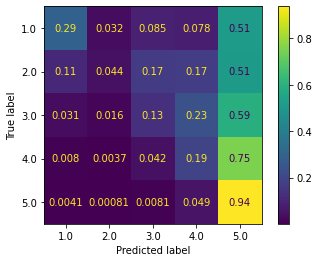

In [9]:
# Apply SVD as dimentionality reduction technique in pipeline with the random forest model.
# At the end plot the confusion matric of the produced model
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.2)
svd = TruncatedSVD(n_components=100)
rf_model = RandomForestClassifier(n_jobs=-1)
rf_model = make_pipeline(svd, rf_model)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = (accuracy_score(y_pred, y_test) * 100).__round__(2)
print("Accuracy for RandomForestClassifier is {}".format(accuracy))
final_predictions = pd.DataFrame(rf_model.predict(test_X))[0]
submission_data["Score"] = final_predictions
submission_data.to_csv('rf_submission.csv',index=False)
plot_confusion_matrix(rf_model, X_test, y_test, normalize='true')